# Data Mining Project - To Loan or Not to Loan

## Table of contents

1. [Introduction](#Introduction)

2. [Required libraries](#Required-libraries)

4. [The Problem](#Problem)

5. [Initialization / Preprocessing](#Initialization-/-Preprocessing)

6. [Plots](#Plots)

7. [Exploratory analysis](#Step-4:-Exploratory-analysis)

8. [Classification](#Step-5:-Classification)

    - [Cross-validation](#Cross-validation)

    - [Parameter tuning](#Parameter-tuning)

9. [Conclusions](#Conclusions)

## Introduction

In this project, we intend to use Supervised Machine Learning methods to predict whether a loan should be refused or not. In order to do this, we make use of a [Bank Loan dataset](https://www.kaggle.com/c/to-loan-or-not-to-loan-that-is-the-question-ac2122) from a Kaggle competition.

## Required libraries

(mudar isto depois)

- **numpy** - provides support for large multidimensional arrays and matrices along with a collection of high-level mathematical functions to execute these functions swiftly.
- **pandas** - enables the provision of easy data structure and quicker data analysis for Python. For operations like data analysis and modelling, Pandas makes it possible to carry these out without needing to switch to more domain-specific language.
- **scikit-learn** - can be effectively used for a variety of applications which include classification, regression, clustering, model selection, naive Bayes’, grade boosting, K-means, and preprocessing.
- **matplotlib** - widely used for publication of quality figures in a variety of hard copy formats and interactive environments across platforms. Used to design charts, graphs, pie charts, scatterplots, histograms, error charts, etc.
- **seaborn** - visualisation of statistical models like heat maps.

## Initialization / Preprocessing

### Import modules

In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

import category_encoders as ce

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import fbeta_score

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import matthews_corrcoef

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.impute import KNNImputer


from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier



## Cleaning Data

### Accounts details data

In [2]:
df_accounts = pd.read_csv('datasets/account.csv', sep=';')

print('Frequency unique values:', df_accounts['frequency'].unique())

Frequency unique values: ['monthly issuance' 'issuance after transaction' 'weekly issuance']


In [3]:
# Using binary encoding on frequency column 

binary_encoder = ce.BinaryEncoder(cols=['frequency'],return_df=True)
df_accounts = binary_encoder.fit_transform(df_accounts)

In [4]:
# Formatting date column

df_accounts['date'] = '19' + df_accounts['date'].astype('str')
df_accounts['date'] = pd.to_datetime(df_accounts.date, format="%Y%m%d")
df_accounts = df_accounts.rename(columns={"date": "account_date"})

df_accounts.to_csv('clean_datasets/account.csv', index=False)
df_accounts.head()

,account_id,district_id,frequency_0,frequency_1,account_date
0,576,55,0,1,1993-01-01
1,3818,74,0,1,1993-01-01
2,704,55,0,1,1993-01-01
3,2378,16,0,1,1993-01-01
4,2632,24,0,1,1993-01-02


### Client details

**birth_number** 
- YYMMDD format for Men
- YYMM+50DD format for Women

In [5]:
df_clients = pd.read_csv('datasets/client.csv', sep=';')
df_clients.head()

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


#### Create column for client's sex and reformat birth date 

**sex**
- 0 - Woman
- 1 - Man

In [6]:
df_clients['sex'] = df_clients['birth_number'].apply(lambda bn: "WOMAN" if ((bn/100)%100) >= 51 else "MAN")

df_clients['birth_date'] = df_clients['birth_number'].apply(lambda bn: pd.to_datetime("19" + str(bn - 5000), format="%Y%m%d") if ((bn/100)%100) >= 51 else pd.to_datetime("19" + str(bn)))

df_clients = df_clients.drop(columns=['birth_number'])
df_clients.to_csv('clean_datasets/client.csv', index=False)
df_clients.head()

,client_id,district_id,sex,birth_date
0,1,18,WOMAN,1970-12-13
1,2,1,MAN,1945-02-04
2,3,1,WOMAN,1940-10-09
3,4,5,MAN,1956-12-01
4,5,5,WOMAN,1960-07-03


### Disposition data

In [7]:
df_disp = pd.read_csv('datasets/disp.csv', sep=';')
df_disp.head()

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [8]:
print('All unique Disposition types: ', df_disp['type'].unique())

All unique Disposition types:  ['OWNER' 'DISPONENT']


#### Label encoding 'type' column

- 0 - OWNER
- 1 - DISPONENT

In [9]:
#df_disp['type'] = df_disp['type'].apply(lambda x: 0 if x == "OWNER" else 1)
#df_disp.head()

df_disp.to_csv('clean_datasets/disp.csv', index=False)

### District data

In [10]:
df_district = pd.read_csv('datasets/district.csv', sep=';')
df_district.head()

,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [11]:
print(len(df_district['region'].unique()), ' different regions: ', df_district['region'].unique())

8  different regions:  ['Prague' 'central Bohemia' 'south Bohemia' 'west Bohemia' 'north Bohemia'
 'east Bohemia' 'south Moravia' 'north Moravia']


In [12]:
df_district['region'] = df_district['region'].astype('category')

print(df_district.columns)

Index(['code ', 'name ', 'region', 'no. of inhabitants',
       'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'unemploymant rate '95 ', 'unemploymant rate '96 ',
       'no. of enterpreneurs per 1000 inhabitants ',
       'no. of commited crimes '95 ', 'no. of commited crimes '96 '],
      dtype='object')


**Problems** - Some column names have a space at the end of the string. And 'region' column should be encoded.

In [13]:
# Using binary encoding on region column 

binary_encoder = ce.BinaryEncoder(cols=['region'],return_df=True)
df_district = binary_encoder.fit_transform(df_district)

In [14]:
for column in df_district.columns:
    df_district = df_district.rename(columns={column : column.strip()})


df_district = df_district.drop(columns=['name'])
df_district.head()

,code,region_0,region_1,region_2,region_3,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,0,0,0,1,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,0,0,1,0,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,0,0,1,0,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,0,0,1,0,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,0,0,1,0,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


#### Looking for Missing Values

In [15]:
df_district.isnull().values.any()

missing = False

for column in df_district.drop(columns=['region_0', 'region_1', 'region_2', 'region_3']).columns:
    if df_district[column].isnull().values.any():
        missing = True
        break
        
if not missing:
    print("No missing values in the data frame")
else:
    print("Missing values present in data frame")

No missing values in the data frame


Now that we have verified that there are no missing values in the district dataset, we must check that every column except `region` have **numeric** values

In [16]:
columns = []
is_numeric = []

for column in df_district.drop(columns=['region_0', 'region_1', 'region_2', 'region_3']).columns:
    columns.append(column)
    is_numeric.append(np.issubdtype(df_district[column].dtype, np.number))


df = pd.DataFrame({'Column' : columns,
                   'Is All Numeric' : is_numeric})
print(tabulate(df, headers='keys', tablefmt='psql'))

+----+--------------------------------------------------+------------------+
|    | Column                                           | Is All Numeric   |
|----+--------------------------------------------------+------------------|
|  0 | code                                             | True             |
|  1 | no. of inhabitants                               | True             |
|  2 | no. of municipalities with inhabitants < 499     | True             |
|  3 | no. of municipalities with inhabitants 500-1999  | True             |
|  4 | no. of municipalities with inhabitants 2000-9999 | True             |
|  5 | no. of municipalities with inhabitants >10000    | True             |
|  6 | no. of cities                                    | True             |
|  7 | ratio of urban inhabitants                       | True             |
|  8 | average salary                                   | True             |
|  9 | unemploymant rate '95                            | False            |

It seems that two columns that should be numeric **have some not numeric values**. It could be that some values are badly formatted numbers or invalid values that make this entry count as a missing value.

In [17]:
df_not_numeric = pd.DataFrame({"unemploymant rate '95":df_district["unemploymant rate '95"].values, "no. of commited crimes '95": df_district["no. of commited crimes '95"].values})

df_not_numeric["not_numeric1"] = df_not_numeric["unemploymant rate '95"].apply(lambda x: x if not x.replace('.', '', 1).isdigit() else "")
df_not_numeric["not_numeric2"] = df_not_numeric["no. of commited crimes '95"].apply(lambda x: x if not x.replace('.', '', 1).isdigit() else "")

print("Not numeric values in 'unemploymant rate '95': ", set(df_not_numeric["not_numeric1"].unique()) - set(['']))
print("Not numeric values in 'no. of commited crimes '95': ",set(df_not_numeric["not_numeric2"].unique()) - set(['']))

Not numeric values in 'unemploymant rate '95':  {'?'}
Not numeric values in 'no. of commited crimes '95':  {'?'}


As there are values in these columns marked as '?', we assume them as **missing values** and should remove them, for a correct missing values handling later on.

In [18]:
df_district["unemploymant rate '95"] = df_district["unemploymant rate '95"].apply(lambda x: x if not x == '?' else None)
df_district["no. of commited crimes '95"] = df_district["no. of commited crimes '95"].apply(lambda x: x if not x == '?' else None)

print("Missing values in 'unemploymant rate '95':", df_district["unemploymant rate '95"].isnull().values.sum())
print("Missing values in 'no. of commited crimes '95': ", df_district["no. of commited crimes '95"].isnull().values.sum())

Missing values in 'unemploymant rate '95': 1
Missing values in 'no. of commited crimes '95':  1


In [19]:
# Sum crimes 95 and 96

#df_district["no. of commited crimes '95"] = pd.to_numeric(df_district["no. of commited crimes '95"])
#df_district["no. of commited crimes '96"] = pd.to_numeric(df_district["no. of commited crimes '96"])

#df_district["no. of commited crimes '95"] += df_district["no. of commited crimes '96"] 
#df_district = df_district.drop(columns=["no. of commited crimes '96"]).rename(columns={"no. of commited crimes '95": "no. of commited crimes '95-96"})

#### Handling Missing Values

In this data table there are a couple of values missing from two columns. As most classification algorithms do not work with missing values, and dropping the rows is not a viable option since we need the data from all districts to join correctly with all the other data, **data imputation** should be used.

In this case, a **K-Nearest-Neighboor** Imputer will be used.

In [20]:
imputer = KNNImputer(n_neighbors=5, weights="uniform")

df_district = pd.DataFrame(imputer.fit_transform(df_district), columns = df_district.columns)

for column in (set(df_district.columns) - set(("ratio of urban inhabitants", "unemploymant rate '95", "unemploymant rate '96"))):
    df_district[column] = df_district[column].astype('int')

#### Merging related columns

In [21]:
df_district["unemploymant rate 95-96"] = (df_district["unemploymant rate '95"] + df_district["unemploymant rate '96"])/2
df_district = df_district.drop(columns=["unemploymant rate '95", "unemploymant rate '96"])

In [22]:
df_district["commited crimes 95-96"] = (df_district["no. of commited crimes '95"] + df_district["no. of commited crimes '96"])
df_district = df_district.drop(columns=["no. of commited crimes '95", "no. of commited crimes '96"])

In [23]:
df_district.head()

,code,region_0,region_1,region_2,region_3,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,no. of enterpreneurs per 1000 inhabitants,unemploymant rate 95-96,commited crimes 95-96
0,1,0,0,0,1,1204953,0,0,0,1,1,100.0,12541,167,0.360,184784
1,2,0,0,1,0,88884,80,26,6,2,5,46.7,8507,132,1.760,4833
2,3,0,0,1,0,75232,55,26,4,1,5,41.7,8980,111,2.080,5637
3,4,0,0,1,0,149893,63,29,6,2,6,67.4,9753,109,4.845,11136
4,5,0,0,1,0,95616,65,30,4,1,6,51.4,9307,118,4.140,5656


In [24]:
df_district = df_district.rename(columns={"code":"district_id"})
df_district.to_csv('clean_datasets/district.csv', index=False)

### Loan Data

In [25]:
df_loan_train = pd.read_csv('datasets/loan_train.csv', sep=";")
df_loan_test = pd.read_csv('datasets/loan_test.csv', sep=";")

In [26]:
df_loans = pd.concat([df_loan_train.drop(columns=["status"]), df_loan_test.drop(columns=["status"])])

df_loans.head()

,loan_id,account_id,date,amount,duration,payments
0,5314,1787,930705,96396,12,8033
1,5316,1801,930711,165960,36,4610
2,6863,9188,930728,127080,60,2118
3,5325,1843,930803,105804,36,2939
4,7240,11013,930906,274740,60,4579


#### Loan dates from number to datetime format

In [27]:
df_loans.date = df_loans.date.apply(lambda x: pd.to_datetime("19" + str(x), format="%Y%m%d"))
df_loans = df_loans.rename(columns={"date": "loan_date"})
df_loans.loan_date = df_loans.loan_date.astype('datetime64[ns]')
df_loans.head()

,loan_id,account_id,loan_date,amount,duration,payments
0,5314,1787,1993-07-05,96396,12,8033
1,5316,1801,1993-07-11,165960,36,4610
2,6863,9188,1993-07-28,127080,60,2118
3,5325,1843,1993-08-03,105804,36,2939
4,7240,11013,1993-09-06,274740,60,4579


In [28]:
df_loans_train_clean = df_loans[df_loans['loan_id'].isin(df_loan_train['loan_id'].values)]
df_loans_train_clean['status'] = df_loan_train['status']
df_loans_train_clean.to_csv('clean_datasets/loans_train.csv', index=False)

df_loans_test_clean = df_loans[df_loans['loan_id'].isin(df_loan_test['loan_id'].values)]
df_loans_test_clean['status'] = df_loan_test['status']
df_loans_test_clean.to_csv('clean_datasets/loans_test.csv', index=False)

<ipython-input-28-ac172a8b49de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loans_train_clean['status'] = df_loan_train['status']
<ipython-input-28-ac172a8b49de>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loans_test_clean['status'] = df_loan_test['status']


### Cards Data

In [29]:
df_card_train = pd.read_csv('datasets/card_train.csv', sep=";")
df_card_test = pd.read_csv('datasets/card_test.csv', sep=";")

In [30]:
df_cards = pd.concat([df_card_train, df_card_test])

df_cards.head()

,card_id,disp_id,type,issued
0,1005,9285,classic,931107
1,104,588,classic,940119
2,747,4915,classic,940205
3,70,439,classic,940208
4,577,3687,classic,940215


#### Card issuance dates from number to datetime format

In [31]:
df_cards.issued = df_cards.issued.apply(lambda x: pd.to_datetime("19" + str(x), format="%Y%m%d"))
df_cards = df_cards.rename(columns={"issued": "card_date"})
df_cards.card_date = df_cards.card_date.astype('datetime64[ns]')
df_cards.head()

,card_id,disp_id,type,card_date
0,1005,9285,classic,1993-11-07
1,104,588,classic,1994-01-19
2,747,4915,classic,1994-02-05
3,70,439,classic,1994-02-08
4,577,3687,classic,1994-02-15


#### Replace 'type' column categories by numerical values (junior < classic < gold)

In [32]:
type_values = {"junior": -10, "classic": 0, "gold": 10}
df_cards['type'] = df_cards['type'].apply(lambda x: type_values[x])
df_cards.head()

,card_id,disp_id,type,card_date
0,1005,9285,0,1993-11-07
1,104,588,0,1994-01-19
2,747,4915,0,1994-02-05
3,70,439,0,1994-02-08
4,577,3687,0,1994-02-15


In [33]:
df_card_train_clean = df_cards[df_cards['card_id'].isin(df_card_train['card_id'].values)]
df_card_train_clean.to_csv('clean_datasets/cards_train.csv', index=False)

df_card_test_clean = df_cards[df_cards['card_id'].isin(df_card_test['card_id'].values)]
df_card_test_clean.to_csv('clean_datasets/cards_test.csv', index=False)

## Merging the Data

In [34]:
df_loan_train = pd.read_csv('clean_datasets/loans_train.csv', parse_dates=['loan_date'], date_parser=pd.to_datetime)
df_loan_test = pd.read_csv('clean_datasets/loans_test.csv', parse_dates=['loan_date'], date_parser=pd.to_datetime)

In [35]:
df_accounts_test = pd.read_csv('clean_datasets/account.csv', parse_dates=['account_date'], date_parser=pd.to_datetime)

In [36]:
df_districts_test = pd.read_csv('clean_datasets/district.csv', dtype={"region":"category"})
df_districts_test = df_districts_test.reset_index()

In [37]:
merge_train = pd.merge(df_loan_train, df_accounts_test, on = 'account_id', how='left')
merge_train = pd.merge(merge_train, df_districts_test, on = 'district_id',how='left')

In [38]:
merge_test = pd.merge(df_loan_test, df_accounts_test, on = 'account_id', how='left')
merge_test = pd.merge(merge_test, df_districts_test, on = 'district_id',how='left')

In [39]:
merge_train.head()

,loan_id,account_id,loan_date,amount,duration,payments,status,district_id,frequency_0,frequency_1,...,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,no. of enterpreneurs per 1000 inhabitants,unemploymant rate 95-96,commited crimes 95-96
0,5314,1787,1993-07-05,96396,12,8033,-1,30,1,1,...,15,13,8,2,10,81.8,9650,100,3.525,5789
1,5316,1801,1993-07-11,165960,36,4610,1,46,0,1,...,48,20,7,3,10,73.5,8369,117,2.050,5472
2,6863,9188,1993-07-28,127080,60,2118,1,45,0,1,...,85,19,6,1,5,53.5,8390,132,2.585,4202
3,5325,1843,1993-08-03,105804,36,2939,1,12,0,1,...,84,29,6,1,6,58.0,8754,137,4.070,7672
4,7240,11013,1993-09-06,274740,60,4579,1,1,1,1,...,0,0,0,1,1,100.0,12541,167,0.360,184784


In [40]:
merge_train['time_since_create'] = (merge_train["loan_date"] - merge_train["account_date"]).dt.days
merge_train = merge_train.drop(columns=["account_date", "loan_date", "index"])

merge_test['time_since_create'] = (merge_test["loan_date"] - merge_test["account_date"]).dt.days
merge_test = merge_test.drop(columns=["account_date", "loan_date", "index"])

In [41]:
merge_train.head()

,loan_id,account_id,amount,duration,payments,status,district_id,frequency_0,frequency_1,region_0,...,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,no. of enterpreneurs per 1000 inhabitants,unemploymant rate 95-96,commited crimes 95-96,time_since_create
0,5314,1787,96396,12,8033,-1,30,1,1,0,...,13,8,2,10,81.8,9650,100,3.525,5789,105
1,5316,1801,165960,36,4610,1,46,0,1,0,...,20,7,3,10,73.5,8369,117,2.050,5472,148
2,6863,9188,127080,60,2118,1,45,0,1,0,...,19,6,1,5,53.5,8390,132,2.585,4202,170
3,5325,1843,105804,36,2939,1,12,0,1,0,...,29,6,1,6,58.0,8754,137,4.070,7672,185
4,7240,11013,274740,60,4579,1,1,1,1,0,...,0,0,1,1,100.0,12541,167,0.360,184784,204


In [42]:
merge_train.to_csv("merge_train.csv", index=False)
merge_test.to_csv("merge_test.csv", index=False)

## Analysis

### Class Balance

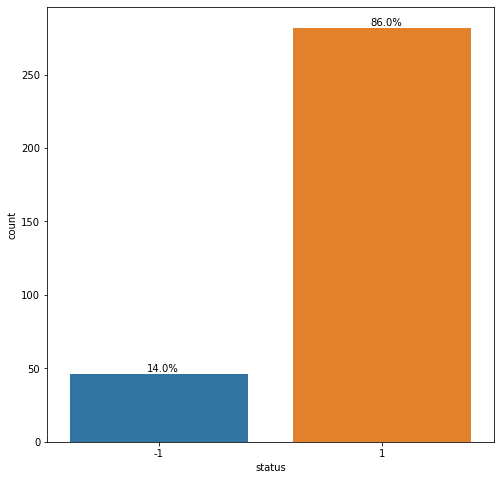

In [110]:
plt.figure(figsize=(8, 8))

cp = sb.countplot(x='status', data=merge_train)
total = len(merge_train)

patchNegative = cp.patches[0]
percentage = '{:.1f}%'.format(100 * patchNegative.get_height() / total)
x = patchNegative.get_x() + (patchNegative.get_width() / 2.3)
y = patchNegative.get_y() + patchNegative.get_height() + 1.5
cp.annotate(percentage, (x, y))

patchPositive = cp.patches[1]
percentage = '{:.1f}%'.format(100 * patchPositive.get_height() / total)
x = patchPositive.get_x() + (patchPositive.get_width() / 2.3)
y = patchPositive.get_y() + patchPositive.get_height() + 1.5
cp.annotate(percentage, (x, y))

plt.show()

This dataset is **very unbalanced**. Only 14% of the rows are relative to refused loans.

## Classification

### Validation Technique

#### Stratified Cross Validation

In [81]:
def train_model(model, train, test, fold_no):
    
    X_train = train[train.columns.difference(['status'])]
    y_train = train['status']
    X_test = test[test.columns.difference(["status"])]
    y_test = test['status']
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions_proba = model.predict_proba(X_test)
    predictions_proba = predictions_proba[:,1]
    
    precision, recall, _ = precision_recall_curve(y_test, predictions_proba)
    plt.plot(recall, precision, alpha=0.3,
                 label='PR fold %d (AP = %0.2f, AUC = %0.2f)' % (fold_no, average_precision_score(y_test, predictions_proba), auc(recall, precision)))
    return (model, X_train, y_train, X_test, y_test, predictions_proba, predictions)
    
def cross_val(model, df, n_splits):
    results = []
    target = df['status'].values
    skf = StratifiedKFold(n_splits=n_splits)
    
    fold_no = 1
    for train_index, test_index in skf.split(df, target):
        train = df.iloc[train_index]
        test = df.iloc[test_index]
        results.append(train_model(model, train, test, fold_no))
        fold_no += 1

    y_test_all = []
    predictions_proba_all = []
    predictions_all = []

    for result in results:
        (_, _, _, _, y_test, predictions_proba, predictions) = result
        y_test_all.append(y_test)
        predictions_proba_all.append(predictions_proba)
        predictions_all.append(predictions)
        
    y_test_all = np.concatenate(y_test_all)
    predictions_proba_all = np.concatenate(predictions_proba_all)
    predictions_all = np.concatenate(predictions_all)
    
    precision, recall, _ = precision_recall_curve(y_test_all, predictions_proba_all)

    plt.rcParams["figure.figsize"] = 10,7
    plt.plot(recall, precision, color='b',
    label=r'PR (AP = %0.2f, AUC = %0.2f)' % (average_precision_score(y_test_all, predictions_proba_all), auc(recall, precision)),
    lw=2, alpha=.8)
    plt.legend()
    plt.title("Precision Recall Curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    return (y_test_all, predictions_proba_all, predictions_all)

### Support Vector Machine

In [44]:

#clf = svm.SVC(kernel='linear', class_weight="balanced")

#clf.fit(merge_train.drop(columns=["status", "loan_id", "account_id", "district_id"]), merge_train['status'])

In [45]:
#y_pred = clf.predict(merge_test.drop(columns=['status', "loan_id", "account_id", "district_id"]))
#print(y_pred)

### Logistic Regression

In [82]:
logreg = LogisticRegression(class_weight='balanced', max_iter=500000)
logreg.fit(merge_train.drop(columns=["status", "loan_id", "account_id", "district_id"]), merge_train['status'])

predictions = logreg.predict(merge_test.drop(columns=['status', "loan_id", "account_id", "district_id"]))

print(predictions)

[ 1 -1  1  1  1  1  1 -1  1  1  1  1 -1 -1 -1 -1 -1  1 -1  1  1  1  1  1
  1  1  1  1 -1 -1 -1  1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1  1
  1  1  1 -1 -1 -1  1  1  1  1  1  1  1 -1  1 -1  1 -1  1  1 -1  1  1 -1
 -1  1 -1 -1 -1  1  1  1 -1 -1  1  1 -1  1  1  1 -1  1 -1 -1  1  1 -1 -1
  1 -1  1  1 -1 -1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1  1 -1  1  1 -1
  1  1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1  1 -1
  1  1 -1 -1  1  1  1  1  1  1 -1  1  1  1  1 -1 -1  1 -1 -1  1  1 -1 -1
  1 -1  1  1 -1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1 -1 -1
  1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1  1  1 -1  1  1 -1  1  1 -1  1  1  1
  1  1  1 -1  1 -1  1  1 -1  1 -1 -1  1  1 -1  1  1  1  1  1 -1 -1  1  1
  1 -1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1 -1  1 -1  1 -1  1  1  1
  1  1  1  1  1 -1  1  1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1  1  1  1 -1 -1  1  1 -1
 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1  1  1  1 -1  1

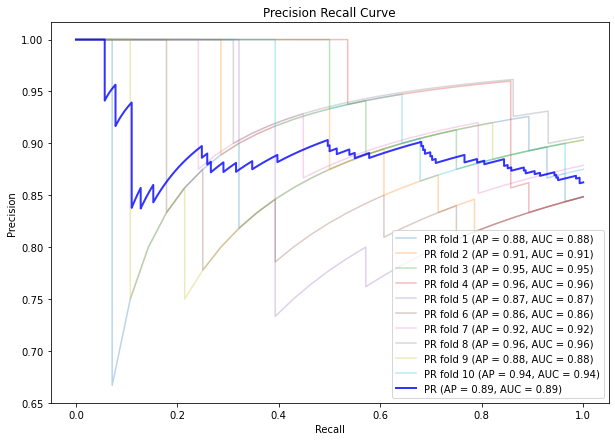

<Figure size 720x504 with 0 Axes>

Classification Report:
              precision    recall  f1-score   support

          -1       0.18      0.54      0.27        46
           1       0.89      0.59      0.71       282

    accuracy                           0.59       328
   macro avg       0.53      0.57      0.49       328
weighted avg       0.79      0.59      0.65       328

F2 Score: 0.6344984802431612
Cohen's Kappa Score: 0.07313829787234039
Matthews Correlation Coefficient (MCC): 0.09525027875660931


Mean Absolute Error (MAE): 0.8292682926829268
Mean Squared Error (MSE): 1.6585365853658536
R Squared: -2.438791242676534


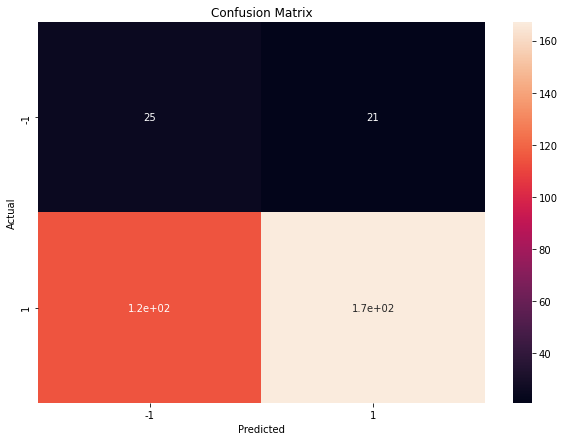

<Figure size 720x504 with 0 Axes>

In [86]:
(testing_classes, predictions_proba, predictions) = cross_val(logreg, merge_train, 10)
plt.figure()
plt.show()

print("Classification Report:")
print(classification_report(testing_classes, predictions))

print("F2 Score: {}".format(fbeta_score(testing_classes, predictions, beta=2)))
print("Cohen's Kappa Score: {}".format(cohen_kappa_score(testing_classes, predictions)))
print("Matthews Correlation Coefficient (MCC): {}".format(matthews_corrcoef(testing_classes, predictions)))
print("\n")
print('Mean Absolute Error (MAE):', mean_absolute_error(testing_classes, predictions))
print('Mean Squared Error (MSE):', mean_squared_error(testing_classes, predictions))
print('R Squared:', r2_score(testing_classes, predictions))

confusion_matrix = pd.crosstab(testing_classes, predictions, rownames=['Actual'], colnames=['Predicted'])
sb.heatmap(confusion_matrix, annot=True)
plt.title("Confusion Matrix")
plt.figure()
plt.draw()

### Decision Tree

In [113]:
dtc = DecisionTreeClassifier()

dtc.fit(merge_train.drop(columns=["status", "loan_id", "account_id", "district_id"]), merge_train['status'])

predictions = dtc.predict(merge_test.drop(columns=['status', "loan_id", "account_id", "district_id"]))

print(predictions)

[ 1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1 -1  1  1  1  1  1  1  1 -1
  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1  1  1 -1 -1 -1 -1  1  1  1
 -1 -1 -1  1 -1  1 -1  1  1 -1  1  1  1  1  1  1 -1  1 -1  1  1  1 -1 -1
  1 -1  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1 -1 -1  1  1  1  1 -1
  1  1 -1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1  1  1  1 -1  1 -1  1  1
  1 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1 -1  1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1 -1  1 -1  1  1 -1  1  1  1 -1 -1  1  1  1  1  1  1  1 -1 -1 -1
  1 -1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1 -1 -1  1  1  1 -1 -1  1  1  1 -1  1  1  1 -1  1  1  1  1
 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1
 -1 -1  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1

Classification Report:
              precision    recall  f1-score   support

          -1       0.24      0.26      0.25        46
           1       0.88      0.87      0.87       282

    accuracy                           0.78       328
   macro avg       0.56      0.56      0.56       328
weighted avg       0.79      0.78      0.79       328



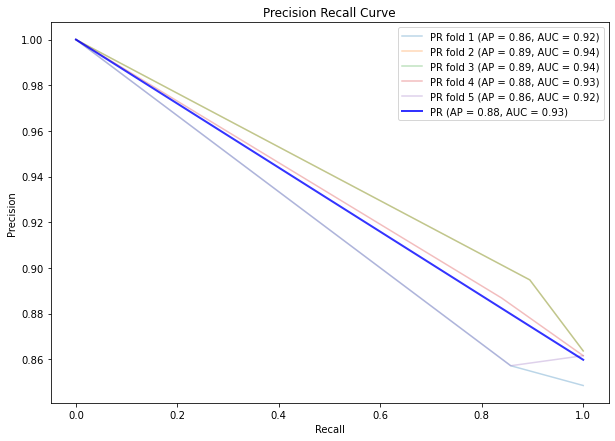

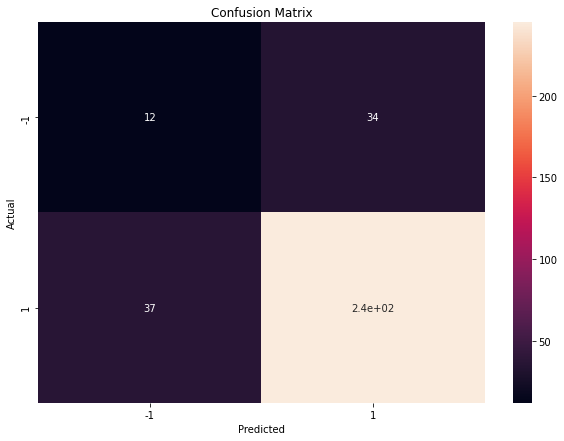

<Figure size 720x504 with 0 Axes>

In [114]:
(testing_classes, predictions_proba, predictions) = cross_val(dtc, merge_train, 5)
plt.figure()
plt.draw()

print("Classification Report:")
print(classification_report(testing_classes, predictions))

confusion_matrix = pd.crosstab(testing_classes, predictions, rownames=['Actual'], colnames=['Predicted'])
sb.heatmap(confusion_matrix, annot=True)
plt.title("Confusion Matrix")
plt.figure()
plt.draw()

In [75]:
df_final = pd.DataFrame({"Id" : merge_test['loan_id'], "Predicted" : predictions})

df_final.to_csv('test.csv', index=False)
print(type(predictions))

<class 'numpy.ndarray'>
